In [1]:
import torch
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from torchvision import datasets, transforms
from PIL import Image

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.metrics.confusion_matrix import ConfusionMatrix
from ignite.handlers import EarlyStopping

In [2]:
# bez tego wysadza kernel kiedy rysuje obrazek
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 64
committee_size = 5
torch.manual_seed(0)

cuda:0


In [5]:
train_data = datasets.CIFAR10("./cifar10", download=True, transform=transforms.ToTensor(), train=True)
test_data = datasets.CIFAR10("./cifar10", download=True, transform=transforms.ToTensor(), train=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# for single model
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [6]:
# for committee
train_loaders = [DataLoader(train_data, batch_size=batch_size, sampler=RandomSampler(train_data, True, len(train_data))) for _ in range(committee_size)]
test_loader = DataLoader(test_data, batch_size=batch_size)

In [7]:
def print_img(img, axs):
    img_np = img.numpy()
    img_denormalized = (img_np*255).astype("uint8").transpose(1, 2, 0) 
    return axs.imshow(img_denormalized)

In [ ]:
fig, axs = plt.subplots(3, 5, constrained_layout=True)
axs = np.reshape(axs, -1)
for x in range(15):
    img, label = train_data[x]
    axs[x].title.set_text(classes[label])
    print_img(img, axs[x])

In [7]:
from typing import Any, Callable, cast, Tuple, Union

import torch

from ignite import distributed as idist
from ignite.exceptions import NotComputableError
from ignite.metrics import EpochMetric


def roc_auc_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor) -> float:
    from sklearn.metrics import roc_auc_score

    y_true = y_targets.cpu().numpy()
    y_pred = y_preds.cpu().numpy()
    return roc_auc_score(y_true, y_pred, multi_class='ovr')


def roc_auc_curve_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor) -> Tuple[Any, Any, Any]:
    from sklearn.metrics import roc_curve

    y_true = y_targets.cpu().numpy()
    y_pred = y_preds.cpu().numpy()
    return roc_curve(y_true, y_pred)



class AUC(EpochMetric):
    """Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    accumulating predictions and the ground-truth during an epoch and applying
    `sklearn.metrics.roc_auc_score <https://scikit-learn.org/stable/modules/generated/
    sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score>`_ .

    Args:
        output_transform: a callable that is used to transform the
            :class:`~ignite.engine.engine.Engine`'s ``process_function``'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.
        check_compute_fn: Default False. If True, `roc_curve
            <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#
            sklearn.metrics.roc_auc_score>`_ is run on the first batch of data to ensure there are
            no issues. User will be warned in case there are any issues computing the function.
        device: optional device specification for internal storage.

    Note:

        ROC_AUC expects y to be comprised of 0's and 1's. y_pred must either be probability estimates or confidence
        values. To apply an activation to y_pred, use output_transform as shown below:

        .. code-block:: python

            def sigmoid_output_transform(output):
                y_pred, y = output
                y_pred = torch.sigmoid(y_pred)
                return y_pred, y
            avg_precision = ROC_AUC(sigmoid_output_transform)

    Examples:

        .. include:: defaults.rst
            :start-after: :orphan:

        .. testcode::

            roc_auc = ROC_AUC()
            #The ``output_transform`` arg of the metric can be used to perform a sigmoid on the ``y_pred``.
            roc_auc.attach(default_evaluator, 'roc_auc')
            y_pred = torch.tensor([[0.0474], [0.5987], [0.7109], [0.9997]])
            y_true = torch.tensor([[0], [0], [1], [0]])
            state = default_evaluator.run([[y_pred, y_true]])
            print(state.metrics['roc_auc'])

        .. testoutput::

            0.6666...
    """

    def __init__(
        self,
        output_transform: Callable = lambda x: x,
        check_compute_fn: bool = False,
        device: Union[str, torch.device] = torch.device("cpu"),
    ):

        try:
            from sklearn.metrics import roc_auc_score  # noqa: F401
        except ImportError:
            raise ModuleNotFoundError("This contrib module requires scikit-learn to be installed.")

        super(AUC, self).__init__(
            roc_auc_compute_fn, output_transform=output_transform, check_compute_fn=check_compute_fn, device=device
        )




class RocCurve(EpochMetric):
    """Compute Receiver operating characteristic (ROC) for binary classification task
    by accumulating predictions and the ground-truth during an epoch and applying
    `sklearn.metrics.roc_curve <https://scikit-learn.org/stable/modules/generated/
    sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve>`_ .

    Args:
        output_transform: a callable that is used to transform the
            :class:`~ignite.engine.engine.Engine`'s ``process_function``'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.
        check_compute_fn: Default False. If True, `sklearn.metrics.roc_curve
            <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#
            sklearn.metrics.roc_curve>`_ is run on the first batch of data to ensure there are
            no issues. User will be warned in case there are any issues computing the function.
        device: optional device specification for internal storage.

    Note:
        RocCurve expects y to be comprised of 0's and 1's. y_pred must either be probability estimates or confidence
        values. To apply an activation to y_pred, use output_transform as shown below:

        .. code-block:: python

            def sigmoid_output_transform(output):
                y_pred, y = output
                y_pred = torch.sigmoid(y_pred)
                return y_pred, y
            avg_precision = RocCurve(sigmoid_output_transform)

    Examples:

        .. include:: defaults.rst
            :start-after: :orphan:

        .. testcode::

            roc_auc = RocCurve()
            #The ``output_transform`` arg of the metric can be used to perform a sigmoid on the ``y_pred``.
            roc_auc.attach(default_evaluator, 'roc_auc')
            y_pred = torch.tensor([0.0474, 0.5987, 0.7109, 0.9997])
            y_true = torch.tensor([0, 0, 1, 0])
            state = default_evaluator.run([[y_pred, y_true]])
            print("FPR", [round(i, 3) for i in state.metrics['roc_auc'][0].tolist()])
            print("TPR", [round(i, 3) for i in state.metrics['roc_auc'][1].tolist()])
            print("Thresholds", [round(i, 3) for i in state.metrics['roc_auc'][2].tolist()])

        .. testoutput::

            FPR [0.0, 0.333, 0.333, 1.0]
            TPR [0.0, 0.0, 1.0, 1.0]
            Thresholds [2.0, 1.0, 0.711, 0.047]

    ..  versionchanged:: 0.4.11
        added `device` argument
    """

    def __init__(
        self,
        output_transform: Callable = lambda x: x,
        check_compute_fn: bool = False,
        device: Union[str, torch.device] = torch.device("cpu"),
    ) -> None:

        try:
            from sklearn.metrics import roc_curve  # noqa: F401
        except ImportError:
            raise ModuleNotFoundError("This contrib module requires scikit-learn to be installed.")

        super(RocCurve, self).__init__(
            roc_auc_curve_compute_fn,  # type: ignore[arg-type]
            output_transform=output_transform,
            check_compute_fn=check_compute_fn,
            device=device,
        )


    def compute(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:  # type: ignore[override]
        if len(self._predictions) < 1 or len(self._targets) < 1:
            raise NotComputableError("RocCurve must have at least one example before it can be computed.")

        _prediction_tensor = torch.cat(self._predictions, dim=0)
        _target_tensor = torch.cat(self._targets, dim=0)

        ws = idist.get_world_size()
        if ws > 1:
            # All gather across all processes
            _prediction_tensor = cast(torch.Tensor, idist.all_gather(_prediction_tensor))
            _target_tensor = cast(torch.Tensor, idist.all_gather(_target_tensor))

        if idist.get_rank() == 0:
            # Run compute_fn on zero rank only
            fpr, tpr, thresholds = cast(Tuple, self.compute_fn(_prediction_tensor, _target_tensor))
            fpr = torch.tensor(fpr, device=_prediction_tensor.device)
            tpr = torch.tensor(tpr, device=_prediction_tensor.device)
            thresholds = torch.tensor(thresholds, device=_prediction_tensor.device)
        else:
            fpr, tpr, thresholds = None, None, None

        if ws > 1:
            # broadcast result to all processes
            fpr = idist.broadcast(fpr, src=0, safe_mode=True)
            tpr = idist.broadcast(tpr, src=0, safe_mode=True)
            thresholds = idist.broadcast(thresholds, src=0, safe_mode=True)

        return fpr, tpr, thresholds


In [8]:
class Committee(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = models

    def forward(self, x):
        predictions = torch.stack([model.forward(x).argmax(1) for model in self.models])
        predictions = torch.stack([predictions[:, i].bincount(minlength=10) for i in range(x.shape[0])]).float()
        return predictions


def plot_confusion_matrix(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

def softmax_output_transform(output):
    y_pred, y = output
    y_pred = torch.softmax(y_pred, 1)
    return y_pred, y


def run_model(model):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)

    val_metrics = {
        "accuracy": Accuracy(device=device),
        "loss": Loss(loss_fn, device=device),
        "auc": AUC(softmax_output_transform, device=device),
        "confusion_matrix": ConfusionMatrix(10, device=device)
    }

    train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
    val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)


    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        train_evaluator.run(train_loader)
        metrics = train_evaluator.state.metrics
        print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}, AUC: {metrics['auc']:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        val_evaluator.run(test_loader)
        metrics = val_evaluator.state.metrics
        # print(metrics["confusion_matrix"])
        print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}, AUC: {metrics['auc']:.2f}")

    def score_function(engine):
        metrics = engine.state.metrics
        return metrics["accuracy"]
    

    val_evaluator.add_event_handler(Events.COMPLETED, EarlyStopping(3, score_function, trainer))

    trainer.run(train_loader, max_epochs=100)
    plot_confusion_matrix(val_evaluator.state.metrics["confusion_matrix"])


def run_models(net_class):
    models = [net_class().to(device) for _ in range(committee_size)]

    for i, model in enumerate(models):
        print(f"Training model #{i + 1}...")

        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        trainer = create_supervised_trainer(model, optimizer, loss_fn, device)

        val_metrics = {
            "accuracy": Accuracy(device=device),
            "loss": Loss(loss_fn, device=device),
            "auc": AUC(softmax_output_transform, device=device)
        }

        train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
        val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)


        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(trainer):
            train_evaluator.run(train_loaders[i])
            metrics = train_evaluator.state.metrics
            print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}, AUC: {metrics['auc']:.2f}")

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_validation_results(trainer):
            val_evaluator.run(test_loader)
            metrics = val_evaluator.state.metrics
            print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}, AUC: {metrics['auc']:.2f}")

        def score_function(engine):
            metrics = engine.state.metrics
            return metrics["accuracy"]


        val_evaluator.add_event_handler(Events.COMPLETED, EarlyStopping(3, score_function, trainer))
        trainer.run(train_loaders[i], max_epochs=100)


    committee = Committee(models)
    
    loss_fn = nn.CrossEntropyLoss()
    val_metrics = {
        "accuracy": Accuracy(device=device),
        "loss": Loss(loss_fn, device=device),
        "auc": AUC(softmax_output_transform, device=device),
        "confusion_matrix": ConfusionMatrix(10, device=device)
    }
    evaluator = create_supervised_evaluator(committee, metrics=val_metrics, device=device)

    @evaluator.on(Events.COMPLETED)
    def log_committee_results(evaluator):
        metrics = evaluator.state.metrics
        print(f"Validation Results - Committee Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}, AUC: {metrics['auc']:.2f}")

    evaluator.run(test_loader)
    plot_confusion_matrix(evaluator.state.metrics["confusion_matrix"])

Training model #1...
Training Results - Epoch[1] Avg accuracy: 55.42%, Avg loss: 1.30, AUC: 0.93
Validation Results - Epoch[1] Avg accuracy: 53.94%, Avg loss: 1.33, AUC: 0.92
Training Results - Epoch[2] Avg accuracy: 61.75%, Avg loss: 1.12, AUC: 0.94
Validation Results - Epoch[2] Avg accuracy: 59.80%, Avg loss: 1.21, AUC: 0.93
Training Results - Epoch[3] Avg accuracy: 66.81%, Avg loss: 1.00, AUC: 0.96
Validation Results - Epoch[3] Avg accuracy: 63.57%, Avg loss: 1.14, AUC: 0.95
Training Results - Epoch[4] Avg accuracy: 65.31%, Avg loss: 1.06, AUC: 0.96
Validation Results - Epoch[4] Avg accuracy: 62.13%, Avg loss: 1.21, AUC: 0.95
Training Results - Epoch[5] Avg accuracy: 78.11%, Avg loss: 0.63, AUC: 0.98
Validation Results - Epoch[5] Avg accuracy: 72.15%, Avg loss: 0.84, AUC: 0.96
Training Results - Epoch[6] Avg accuracy: 81.32%, Avg loss: 0.56, AUC: 0.98
Validation Results - Epoch[6] Avg accuracy: 73.90%, Avg loss: 0.80, AUC: 0.97
Training Results - Epoch[7] Avg accuracy: 82.41%, Avg l

2023-03-27 04:45:53,971 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[17] Avg accuracy: 76.39%, Avg loss: 1.02, AUC: 0.97
Training model #2...
Training Results - Epoch[1] Avg accuracy: 58.14%, Avg loss: 1.17, AUC: 0.93
Validation Results - Epoch[1] Avg accuracy: 56.83%, Avg loss: 1.20, AUC: 0.92
Training Results - Epoch[2] Avg accuracy: 66.52%, Avg loss: 0.97, AUC: 0.95
Validation Results - Epoch[2] Avg accuracy: 64.06%, Avg loss: 1.04, AUC: 0.94
Training Results - Epoch[3] Avg accuracy: 69.69%, Avg loss: 0.91, AUC: 0.96
Validation Results - Epoch[3] Avg accuracy: 65.70%, Avg loss: 1.03, AUC: 0.95
Training Results - Epoch[4] Avg accuracy: 76.43%, Avg loss: 0.69, AUC: 0.98
Validation Results - Epoch[4] Avg accuracy: 70.82%, Avg loss: 0.84, AUC: 0.96
Training Results - Epoch[5] Avg accuracy: 73.60%, Avg loss: 0.82, AUC: 0.97
Validation Results - Epoch[5] Avg accuracy: 67.76%, Avg loss: 1.02, AUC: 0.96
Training Results - Epoch[6] Avg accuracy: 80.70%, Avg loss: 0.57, AUC: 0.98
Validation Results - Epoch[6] Avg accuracy: 72.87%, Av

2023-03-27 04:49:49,845 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[14] Avg accuracy: 77.91%, Avg loss: 0.88, AUC: 0.97
Training model #3...
Training Results - Epoch[1] Avg accuracy: 56.15%, Avg loss: 1.25, AUC: 0.93
Validation Results - Epoch[1] Avg accuracy: 55.91%, Avg loss: 1.29, AUC: 0.93
Training Results - Epoch[2] Avg accuracy: 70.02%, Avg loss: 0.85, AUC: 0.96
Validation Results - Epoch[2] Avg accuracy: 66.74%, Avg loss: 0.93, AUC: 0.95
Training Results - Epoch[3] Avg accuracy: 71.84%, Avg loss: 0.82, AUC: 0.97
Validation Results - Epoch[3] Avg accuracy: 67.63%, Avg loss: 0.95, AUC: 0.96
Training Results - Epoch[4] Avg accuracy: 73.01%, Avg loss: 0.79, AUC: 0.97
Validation Results - Epoch[4] Avg accuracy: 67.75%, Avg loss: 0.97, AUC: 0.96
Training Results - Epoch[5] Avg accuracy: 80.63%, Avg loss: 0.57, AUC: 0.98
Validation Results - Epoch[5] Avg accuracy: 74.40%, Avg loss: 0.77, AUC: 0.97
Training Results - Epoch[6] Avg accuracy: 76.93%, Avg loss: 0.71, AUC: 0.98
Validation Results - Epoch[6] Avg accuracy: 70.41%, Av

2023-03-27 04:53:37,504 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[14] Avg accuracy: 78.34%, Avg loss: 0.87, AUC: 0.97
Training model #4...
Training Results - Epoch[1] Avg accuracy: 55.77%, Avg loss: 1.28, AUC: 0.93
Validation Results - Epoch[1] Avg accuracy: 55.08%, Avg loss: 1.31, AUC: 0.93
Training Results - Epoch[2] Avg accuracy: 56.83%, Avg loss: 1.36, AUC: 0.93
Validation Results - Epoch[2] Avg accuracy: 54.79%, Avg loss: 1.44, AUC: 0.92
Training Results - Epoch[3] Avg accuracy: 64.17%, Avg loss: 1.05, AUC: 0.94
Validation Results - Epoch[3] Avg accuracy: 62.31%, Avg loss: 1.14, AUC: 0.93
Training Results - Epoch[4] Avg accuracy: 66.55%, Avg loss: 1.07, AUC: 0.96
Validation Results - Epoch[4] Avg accuracy: 63.14%, Avg loss: 1.22, AUC: 0.95
Training Results - Epoch[5] Avg accuracy: 77.60%, Avg loss: 0.63, AUC: 0.98
Validation Results - Epoch[5] Avg accuracy: 71.72%, Avg loss: 0.83, AUC: 0.96
Training Results - Epoch[6] Avg accuracy: 81.48%, Avg loss: 0.54, AUC: 0.98
Validation Results - Epoch[6] Avg accuracy: 74.58%, Av

2023-03-27 04:57:08,807 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[13] Avg accuracy: 71.12%, Avg loss: 1.22, AUC: 0.96
Training model #5...
Training Results - Epoch[1] Avg accuracy: 58.32%, Avg loss: 1.16, AUC: 0.93
Validation Results - Epoch[1] Avg accuracy: 57.71%, Avg loss: 1.19, AUC: 0.93
Training Results - Epoch[2] Avg accuracy: 66.68%, Avg loss: 0.95, AUC: 0.95
Validation Results - Epoch[2] Avg accuracy: 65.38%, Avg loss: 1.01, AUC: 0.95
Training Results - Epoch[3] Avg accuracy: 65.91%, Avg loss: 1.02, AUC: 0.96
Validation Results - Epoch[3] Avg accuracy: 62.70%, Avg loss: 1.13, AUC: 0.95
Training Results - Epoch[4] Avg accuracy: 72.93%, Avg loss: 0.80, AUC: 0.97
Validation Results - Epoch[4] Avg accuracy: 68.81%, Avg loss: 0.95, AUC: 0.96
Training Results - Epoch[5] Avg accuracy: 75.98%, Avg loss: 0.71, AUC: 0.98
Validation Results - Epoch[5] Avg accuracy: 70.30%, Avg loss: 0.92, AUC: 0.96
Training Results - Epoch[6] Avg accuracy: 80.01%, Avg loss: 0.58, AUC: 0.98
Validation Results - Epoch[6] Avg accuracy: 73.13%, Av

2023-03-27 05:00:25,100 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[12] Avg accuracy: 76.29%, Avg loss: 0.87, AUC: 0.97
Validation Results - Committee Avg accuracy: 81.64%, Avg loss: 0.65, AUC: 0.97


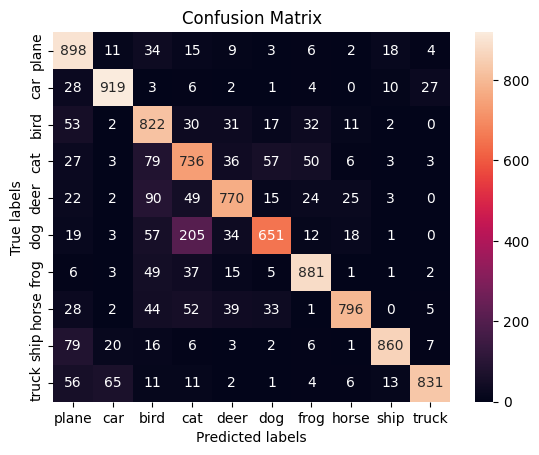

In [9]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64, True)
        self.conv2 = conv_block(64, 128, True)
        self.conv3 = conv_block(128, 128)

        self.fc1 = nn.Linear(512 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(self.conv3(x)) + x

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

run_models(Net)

1 + 3 - Validation Results - Epoch[11] Avg accuracy: 55.59%, Avg loss: 1.34
2 + 3 - Validation Results - Epoch[10] Avg accuracy: 58.85%, Avg loss: 1.34

3 + 3 - Validation Results - Epoch[10] Avg accuracy: 58.77%, Avg loss: 1.23
3 + 4 - Validation Results - Epoch[12] Avg accuracy: 61.44%, Avg loss: 1.42
3 + 5 - Validation Results - Epoch[15] Avg accuracy: 57.74%, Avg loss: 1.47

4 + 3 - Validation Results - Epoch[11] Avg accuracy: 59.61%, Avg loss: 1.36
4 + 4 - Validation Results - Epoch[15] Avg accuracy: 61.82%, Avg loss: 1.52
4 + 5 - Validation Results - Epoch[19] Avg accuracy: 60.91%, Avg loss: 1.24

5 + 3 - Validation Results - Epoch[18] Avg accuracy: 60.97%, Avg loss: 1.17
5 + 4 - Validation Results - Epoch[14] Avg accuracy: 60.22%, Avg loss: 1.24
5 + 5 - Validation Results - Epoch[23] Avg accuracy: 61.34%, Avg loss: 1.33
5 + 6 - Validation Results - Epoch[20] Avg accuracy: 59.16%, Avg loss: 1.23

6 + 3 - Validation Results - Epoch[17] Avg accuracy: 60.48%, Avg loss: 1.22


# with pooling
2 + 2 - Validation Results - Epoch[16] Avg accuracy: 61.48%, Avg loss: 1.09
2 + 3 - Validation Results - Epoch[19] Avg accuracy: 61.46%, Avg loss: 1.11
2 + 4 - Validation Results - Epoch[17] Avg accuracy: 61.60%, Avg loss: 1.10
2 + 5 - Validation Results - Epoch[17] Avg accuracy: 58.76%, Avg loss: 1.23

2 + 2 - Validation Results - Epoch[25] Avg accuracy: 63.66%, Avg loss: 1.10  # 3x3 kernel

2 + 2 - Validation Results - Epoch[65] Avg accuracy: 59.91%, Avg loss: 1.17  # sigmoid
2 + 3 - Validation Results - Epoch[31] Avg accuracy: 56.99%, Avg loss: 1.21  # sigmoid
2 + 4 - Validation Results - Epoch[40] Avg accuracy: 59.25%, Avg loss: 1.17  # sigmoid
2 + 2 - Validation Results - Epoch[22] Avg accuracy: 52.06%, Avg loss: 1.33  # 3x3 kernel sigmoid

3 + 4 - Validation Results - Epoch[15] Avg accuracy: 65.09%, Avg loss: 1.09  # 3x3 kernel, no pooling on last conv, no relu between conv and pool
3 + 5 - Validation Results - Epoch[20] Avg accuracy: 65.20%, Avg loss: 1.11  # 3x3 kernel, no pooling on last conv, no relu between conv and pool
3 + 5 - Validation Results - Epoch[22] Avg accuracy: 64.24%, Avg loss: 1.11  # 3v3 kernel, no pooling on last conv

3 + 5 - Validation Results - Epoch[14] Avg accuracy: 71.76%, Avg loss: 0.91  # 3v3 kernel, no pooling on last conv, 3 -> 64 -> 128 -> 128 channels

Validation Results - Epoch[11] Avg accuracy: 76.68%, Avg loss: 0.89  # architecture from https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c + 5 fc
Validation Results - Epoch[14] Avg accuracy: 77.51%, Avg loss: 0.99  # j.w. + 4 fc, last with relu
Validation Results - Epoch[11] Avg accuracy: 77.01%, Avg loss: 0.81  # architecture from https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c -- 3 conv + 5 fc, res on last conv
Validation Results - Epoch[16] Avg accuracy: 77.53%, Avg loss: 0.96  # architecture from https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c -- 2 conv + res + 4 fc, res on last conv which is double (actually as in article)  -- left in model in commit
Validation Results - Epoch[13] Avg accuracy: 67.98%, Avg loss: 1.30  # same as above but two res modules
Validation Results - Epoch[12] Avg accuracy: 70.42%, Avg loss: 1.37  # 2 conv + res + 1 conv + 4 fc
Validation Results - Epoch[10] Avg accuracy: 68.59%, Avg loss: 1.47  # 2 conv + res + 2 conv + res + 4 fc
Validation Results - Epoch[11] Avg accuracy: 69.94%, Avg loss: 1.33  # 2 conv + res + 2 conv + res + 5 fc

Validation Results - Committee Avg accuracy: 81.64%, Avg loss: 0.65, AUC: 0.97